# First add steamer and reader functions


In [1]:
import warnings
warnings.filterwarnings('ignore')

import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import STOPWORDS,WordCloud
import pandas as pd
import statistics
import string
import os
import re
import sys
import inspect
import numpy as np

In [4]:
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()

def get_stem_word(text: str) -> str:
    
    stemmed_words = []
    sent_list = text.split()
    
    for word in sent_list:
        try:
            stemmed_words.append(stemmer.stem(word)) 
        except:
             stemmed_words.append(word)
    return ' '.join(stemmed_words)


In [5]:
# path for the cleaned data we are going to use
csv_path = "../cleanedPre_gl_tweeter_data.csv"

# taking a csv file path and reading a dataframe
def read_proccessed_data(csv_path: str):
    try:    
        df = pd.read_csv(csv_path)
        print("csv read")
        return df
    
    except FileNotFoundError:
        print("file not found")

# 1. Sentiment Analysis

In [36]:
pip install wordcloud


In [6]:
import pandas as pd
import sys,os
from wordcloud import STOPWORDS,WordCloud
sys.path.append(os.path.abspath(os.path.join('..')))

In [7]:
# reading the data

df = read_proccessed_data(csv_path)

csv read


In [8]:
#inspect col.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21997 entries, 0 to 21996
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   created_at          21997 non-null  object 
 1   source              21997 non-null  object 
 2   original_text       21997 non-null  object 
 3   retweet_text        0 non-null      float64
 4   sentiment           21997 non-null  int64  
 5   polarity            21997 non-null  float64
 6   subjectivity        21997 non-null  float64
 7   lang                21997 non-null  object 
 8   favorite_count      21997 non-null  int64  
 9   retweet_count       21997 non-null  int64  
 10  original_author     21997 non-null  object 
 11  followers_count     21997 non-null  int64  
 12  friends_count       21997 non-null  int64  
 13  possibly_sensitive  6190 non-null   object 
 14  hashtags            19138 non-null  object 
 15  user_mentions       18695 non-null  object 
 16  plac

In [9]:
# inspecting polarity
df['polarity']
df['polarity'].value_counts()

 0.000000    8982
-0.100000     872
 0.133333     781
 0.500000     502
 0.200000     451
             ... 
-0.900000       1
 0.088571       1
 0.140741       1
-0.004167       1
-0.021212       1
Name: polarity, Length: 917, dtype: int64

In [10]:
# sum of null values in clean text and polarity columns
text_null_sum = df['clean_text'].isnull().sum()
polarity_null_sum = df['polarity'].isnull().sum()

print(f'In clean_text column there are {text_null_sum} NULL Values')
print(f'In polarity cloumn there are {polarity_null_sum} NULL values')

In clean_text column there are 0 NULL Values
In polarity cloumn there are 0 NULL values


In [11]:
# create a model ready table
tweets_df = pd.DataFrame(columns=['clean_text', 'sentiment', 'hashtags', 'lang'])

tweets_df['sentiment'] =  df['sentiment'].to_list()
tweets_df['lang'] = df['lang'].to_list()
tweets_df['hashtags'] = df['hashtags'].to_list()
tweets_df['clean_text'] = df['clean_text'].to_list()

tweets_df.head()

,clean_text,sentiment,hashtags,lang
0,rt : extra random image (i):\n\nlets focus in ...,0,city,en
1,rt : #china's media explains the military reas...,0,china,en
2,china even cut off communication they don't an...,-1,xijinping,en
3,putin to #xijinping : i told you my friend tai...,1,xijinping,en
4,rt : i m sorry i thought taiwan was an indepen...,0,NaN,en


In [14]:
tweets_df['retweet_text'] =  tweets_df['clean_text'].astype(str)
tweets_df['clean_text']= tweets_df['clean_text'].apply(lambda x: x.translate(str.maketrans(' ', ' ', string.punctuation)))
tweets_df['sentiment'] =  tweets_df['sentiment'].astype(int)
tweets_df['hashtags'] = tweets_df['hashtags'].astype(str)
tweets_df['hashtags'] = tweets_df['hashtags'].apply(lambda x: x.lower())
tweets_df['hashtags']= tweets_df['hashtags'].apply(lambda x: x.translate(str.maketrans(' ', ' ', string.punctuation)))

In [15]:
tweets_df.to_csv('../data/model_ready_data.csv', index=False)
print('Model Ready Data Successfully Saved.!!!')

Model Ready Data Successfully Saved.!!!


In [16]:
tweets_df.drop(tweets_df[tweets_df['sentiment'] == -1].index, inplace=True)
tweets_df.reset_index(drop=True, inplace=True)

In [17]:
flattened_words_df = pd.DataFrame(
    [word for words_list in tweets_df['retweet_text']
    for word in words_list.split(' ')],
    columns=['word'])

flattened_words_df.head()

,word
0,rt
1,:
2,extra
3,random
4,image


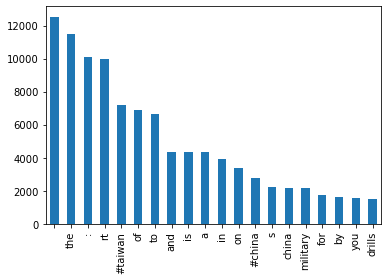

In [18]:
flattened_words_df['word'].value_counts()[:20].plot(kind='bar')


In [19]:
flattened_hashtags_df = pd.DataFrame(
    [hashtag for hashtags_list in tweets_df.hashtags
    for hashtag in hashtags_list.split(',')],
    columns=['hashtag'])

flattened_hashtags_df.drop(flattened_hashtags_df[flattened_hashtags_df['hashtag'] == ""].index, inplace=True)
flattened_hashtags_df.reset_index(drop=True, inplace=True)
flattened_hashtags_df.head()

,hashtag
0,city
1,china
2,xijinping
3,nan
4,taiwan


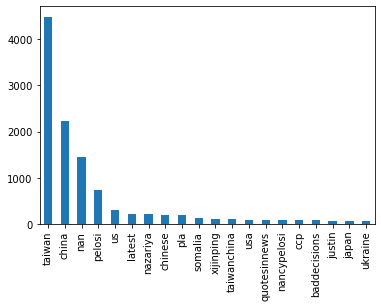

In [20]:
flattened_hashtags_df.hashtag.value_counts()[:20].plot(kind='bar')

 # 1.1 Sentimental modeling 

In [21]:
import pandas as pd
import joblib
import pickle

model_tweets = pd.read_csv('../data/model_ready_data.csv')
model_tweets = model_tweets.fillna("")
model_tweets.head()



,clean_text,sentiment,hashtags,lang,retweet_text
0,rt extra random image i\n\nlets focus in one ...,0,city,en,rt : extra random image (i):\n\nlets focus in ...
1,rt chinas media explains the military reasons...,0,china,en,rt : #china's media explains the military reas...
2,putin to xijinping i told you my friend taiwa...,1,xijinping,en,putin to #xijinping : i told you my friend tai...
3,rt i m sorry i thought taiwan was an independ...,0,,en,rt : i m sorry i thought taiwan was an indepen...
4,rt we must not let this happen\n\nwe must be ...,1,taiwan,en,rt : we must not let this happen\n\nwe must be...


In [22]:
model_tweets.shape

(13015, 5)

In [23]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from joblib import dump, load # used for saving and loading sklearn objects
from scipy.sparse import save_npz, load_npz # used for saving and loading sparse matrices
from sklearn.decomposition import NMF, LatentDirichletAllocation

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
import numpy as np

In [24]:
sentiment_analysis_tweet_data = model_tweets.copy(deep=True)
sentiment_analysis_tweet_data.drop(sentiment_analysis_tweet_data[sentiment_analysis_tweet_data['sentiment'] == -1].index, inplace=True)
sentiment_analysis_tweet_data.reset_index(drop=True, inplace=True)
tweet_train = sentiment_analysis_tweet_data.iloc[:4492,]
tweet_test = sentiment_analysis_tweet_data.iloc[4493:,]

In [25]:
#unigram count
unigram_vectorizer = CountVectorizer(ngram_range=(1, 1))
unigram_vectorizer.fit(tweet_train['clean_text'].values)

CountVectorizer()

In [26]:
# creating a unigram representation of x
X_train_unigram = unigram_vectorizer.transform(tweet_train['clean_text'].values)

In [27]:
unigram_tf_idf_transformer = TfidfTransformer()
unigram_tf_idf_transformer.fit(X_train_unigram)


TfidfTransformer()

In [28]:
X_train_unigram_tf_idf = unigram_tf_idf_transformer.transform(X_train_unigram)

In [29]:
bigram_vectorizer = CountVectorizer(ngram_range=(1, 10))
bigram_vectorizer.fit(tweet_train['clean_text'].values)


CountVectorizer(ngram_range=(1, 10))

In [30]:
X_train_bigram = bigram_vectorizer.transform(tweet_train['clean_text'].values)

In [31]:
bigram_tf_idf_transformer = TfidfTransformer()
bigram_tf_idf_transformer.fit(X_train_bigram)

TfidfTransformer()

In [32]:
X_train_bigram_tf_idf = bigram_tf_idf_transformer.transform(X_train_bigram)

In [33]:
def train_and_show_scores(X: csr_matrix, y: np.array, title: str) -> None:
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y,train_size=0.75, stratify=y
    )

    clf = SGDClassifier()
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    valid_score = clf.score(X_valid, y_valid)

    global_vars = globals()
    if(valid_score > global_vars['best_score']):
        global_vars['best_model'] = clf
        global_vars['best_model_name'] = title
        global_vars['best_score'] = valid_score

    print(f'{title}\nTrain score: {round(train_score, 2)} ; Validation score: {round(valid_score, 2)}\n')

In [34]:
y_train = tweet_train['sentiment'].values
y_train

array([0, 0, 1, ..., 0, 1, 0], dtype=int64)

In [35]:
best_model = ""
best_model_name = ""
best_score = 0

train_and_show_scores(X_train_unigram, y_train, 'Unigram Counts')
train_and_show_scores(X_train_unigram_tf_idf, y_train, 'Unigram Tf-Idf')
train_and_show_scores(X_train_bigram, y_train, 'Bigram Counts')
train_and_show_scores(X_train_bigram_tf_idf, y_train, 'Bigram Tf-Idf')

Unigram Counts
Train score: 1.0 ; Validation score: 0.93

Unigram Tf-Idf
Train score: 1.0 ; Validation score: 0.94

Bigram Counts
Train score: 1.0 ; Validation score: 0.92

Bigram Tf-Idf
Train score: 1.0 ; Validation score: 0.91



In [36]:
#The best Model is Unigram Tf-Idf with a Validation score of: 0.93. Therefore, run_test_using_model.

def run_test_using_model(best_model: SGDClassifier, model_type: str):
    unigram_vectorizer = CountVectorizer(ngram_range=(1, 1))
    unigram_vectorizer.fit(tweet_test['clean_text'].values)
    X_test_unigram = unigram_vectorizer.transform(tweet_test['clean_text'].values)

    bigram_vectorizer = CountVectorizer(ngram_range=(1, 2))
    bigram_vectorizer.fit(tweet_test['clean_text'].values)
    X_test_bigram = bigram_vectorizer.transform(tweet_test['clean_text'].values)

    y_test = tweet_test['sentiment'].values

    if(model_type == "Unigram Counts"):
        X_test = X_test_unigram

    elif(model_type == "Unigram Tf-Idf"):
        unigram_tf_idf_transformer = TfidfTransformer()
        unigram_tf_idf_transformer.fit(X_test_unigram)
        X_test_unigram_tf_idf = unigram_tf_idf_transformer.transform(X_test_unigram)

        X_test = X_test_unigram_tf_idf

    elif(model_type == "Bigram Counts"):
        X_test = X_test_bigram

    else:
        bigram_tf_idf_transformer = TfidfTransformer()
        bigram_tf_idf_transformer.fit(X_test_bigram)

        X_test_bigram_tf_idf = bigram_tf_idf_transformer.transform(X_test_bigram)
        X_test = X_test_bigram_tf_idf

   
    return best_model.score(X_test,y_test)

In [37]:
# Then save the generated LDA model
sgd = joblib.dump(best_model, '../models/newsentimentalmodel.jl')
print('Model Successfully Saved.!!!')

Model Successfully Saved.!!!


# 2. Topic Modeling

In [5]:
import nltk
nltk.download('stopwords')




[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\amanuel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
import re
#import numpy as np
import pandas as  pd
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])


In [11]:
import pandas as pd
import joblib
import pickle

model_tweets = pd.read_csv('../data/model_ready_data.csv')
model_tweets = model_tweets.fillna("")
model_tweets.head()

,clean_text,sentiment,hashtags,lang,retweet_text
0,rt extra random image i\n\nlets focus in one ...,0,city,en,rt : extra random image (i):\n\nlets focus in ...
1,rt chinas media explains the military reasons...,0,china,en,rt : #china's media explains the military reas...
2,putin to xijinping i told you my friend taiwa...,1,xijinping,en,putin to #xijinping : i told you my friend tai...
3,rt i m sorry i thought taiwan was an independ...,0,,en,rt : i m sorry i thought taiwan was an indepen...
4,rt we must not let this happen\n\nwe must be ...,1,taiwan,en,rt : we must not let this happen\n\nwe must be...


In [13]:
topic_model_data = model_tweets.copy(deep=True)
topic_model_data

,clean_text,sentiment,hashtags,lang,retweet_text
0,rt extra random image i\n\nlets focus in one ...,0,city,en,rt : extra random image (i):\n\nlets focus in ...
1,rt chinas media explains the military reasons...,0,china,en,rt : #china's media explains the military reas...
2,putin to xijinping i told you my friend taiwa...,1,xijinping,en,putin to #xijinping : i told you my friend tai...
3,rt i m sorry i thought taiwan was an independ...,0,,en,rt : i m sorry i thought taiwan was an indepen...
4,rt we must not let this happen\n\nwe must be ...,1,taiwan,en,rt : we must not let this happen\n\nwe must be...
...,...,...,...,...,...
13010,rt a good infographic of chinas missile launc...,1,china,en,rt : a good infographic of #china's missile la...
13011,rt a good infographic of chinas missile launc...,1,china,en,rt : a good infographic of #china's missile la...
13012,thanks pelosi smart move,1,pelosi,en,thanks #pelosi smart move
13013,rt taiwan peoples desire for unification with...,1,taiwan,en,rt : #taiwan people's desire for unification w...


In [14]:
def get_hastags_words_list():
    hashtagList = []
    for hashtags in topic_model_data.hashtags:
        if(hashtags != ""):
            hashtagList += hashtags.split(',')

    return hashtagList

hashtag = get_hastags_words_list()

data = [word for sentence in topic_model_data.clean_text for word in sentence.split(' ')]

In [16]:
hashtag[:10]

['city',
 'china',
 'xijinping',
 'taiwan',
 'taiwan',
 'usa',
 'latest',
 'china',
 'taiwan',
 'marvininu']

In [17]:
data[:10]

['rt',
 '',
 'extra',
 'random',
 'image',
 'i\n\nlets',
 'focus',
 'in',
 'one',
 'very']

In [20]:
data_words = data + hashtag
data_words = [word for word in data_words if word != '']
data_words[:5]



['rt', 'extra', 'random', 'image', 'i\n\nlets']

In [21]:

# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['r', 't']


In [22]:
# Define function for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [27]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['rt']]


In [28]:
data_lemmatized = [word for word in data_lemmatized if word != []]
data_lemmatized[:5]

[['rt'], ['extra'], ['random'], ['image'], ['let']]

In [29]:
# Create Dictionary 
id2word = corpora.Dictionary(data_lemmatized)  
# Create Corpus 
texts = data_lemmatized  
# Term Document Frequency 
corpus = [id2word.doc2bow(text) for text in texts]  
# View 
print(corpus)

[[(0, 1)], [(1, 1)], [(2, 1)], [(3, 1)], [(4, 1)], [(5, 1)], [(6, 1)], [(7, 1)], [(8, 1)], [(9, 1)], [(10, 1)], [(11, 1)], [(12, 1)], [(13, 1)], [(0, 1)], [(14, 1)], [(15, 1)], [(16, 1)], [(17, 1)], [(18, 1)], [(19, 1)], [(20, 1)], [(21, 1)], [(22, 1)], [(23, 1)], [(24, 1)], [(25, 1)], [(26, 1)], [(27, 1)], [(28, 1)], [(29, 1)], [(30, 1)], [(31, 1)], [(32, 1)], [(33, 1)], [(34, 1)], [(35, 1)], [(36, 1)], [(37, 1)], [(14, 1)], [(38, 1)], [(0, 1)], [(39, 1)], [(40, 1)], [(41, 1)], [(42, 1)], [(43, 1)], [(44, 1)], [(17, 1)], [(45, 1)], [(0, 1)], [(4, 1)], [(46, 1)], [(47, 1)], [(0, 1)], [(48, 1)], [(42, 1)], [(49, 1)], [(50, 1)], [(51, 1)], [(52, 1)], [(0, 1)], [(53, 1)], [(54, 1)], [(55, 1)], [(56, 1)], [(57, 1)], [(58, 1)], [(59, 1)], [(60, 1)], [(61, 1)], [(0, 1)], [(62, 1)], [(63, 1)], [(64, 1)], [(65, 1)], [(20, 1)], [(66, 1)], [(67, 1)], [(68, 1)], [(69, 1)], [(70, 1)], [(0, 1)], [(71, 1)], [(14, 1)], [(72, 1)], [(73, 1)], [(0, 1)], [(74, 1)], [(75, 1)], [(53, 1)], [(76, 1)], [(77, 

In [30]:
# Readable View
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:10]]

[[('rt', 1)],
 [('extra', 1)],
 [('random', 1)],
 [('image', 1)],
 [('let', 1)],
 [('focus', 1)],
 [('specific', 1)],
 [('zone', 1)],
 [('western', 1)],
 [('coast', 1)]]

In [31]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [32]:
# Print the keyword of topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.000*"extravagant" + 0.000*"commonplace" + 0.000*"screwing" + '
  '0.000*"doorstep" + 0.000*"advent" + 0.000*"enrage" + '
  '0.000*"osipelongerwarm" + 0.000*"reinforcement" + 0.000*"establish" + '
  '0.000*"osipel"'),
 (1,
  '0.739*"missile" + 0.046*"medium" + 0.000*"advent" + 0.000*"extravagant" + '
  '0.000*"taiwanwhy" + 0.000*"screwing" + 0.000*"doorstep" + '
  '0.000*"reinforcement" + 0.000*"enrage" + 0.000*"establish"'),
 (2,
  '0.667*"launch" + 0.000*"extravagant" + 0.000*"commonplace" + '
  '0.000*"doorstep" + 0.000*"advent" + 0.000*"enrage" + 0.000*"taiwanwhy" + '
  '0.000*"reinforcement" + 0.000*"establish" + 0.000*"osipelongerwarm"'),
 (3,
  '0.716*"china" + 0.027*"response" + 0.000*"baddecision" + '
  '0.000*"quotesinnew" + 0.000*"ukraine" + 0.000*"nancypelosi" + '
  '0.000*"taiwanchina" + 0.000*"taiwanese" + 0.000*"marvininu" + '
  '0.000*"break"'),
 (4,
  '0.573*"good" + 0.105*"nancy" + 0.047*"explain" + 0.000*"advent" + '
  '0.000*"extravagant" + 0.000*"knockon" 

In [33]:
# Compute Perplexity
perplexity_score = lda_model.log_perplexity(corpus)
print('\nPerplexity: ', perplexity_score)  
# a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -24.639684960080587

Coherence Score:  0.6255467495917799


In [34]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.212650 -0.107482       1        1  29.817893
17     0.016041  0.005246       2        1  10.551689
12     0.370250  0.387300       3        1   7.533156
5      0.241363 -0.168721       4        1   7.023031
7      0.208880 -0.101538       5        1   6.256143
3     -0.030373  0.012130       6        1   5.182264
11     0.231895 -0.144424       7        1   5.012590
6     -0.098292  0.016987       8        1   4.691169
15    -0.142373  0.015583       9        1   3.994943
1      0.001889  0.007674      10        1   3.436485
4     -0.042519  0.013499      11        1   3.354614
18    -0.133908  0.016422      12        1   3.288753
14    -0.137901  0.016113      13        1   2.343799
10     0.147052 -0.041274      14        1   2.239816
2     -0.072443  0.015829      15        1   1.387207
9     -0.153383  0.012427      16        1   1.114379
19    -0.154705  0.011064      17        1   0.865952
16    -0.154708  0.011056      18        1   0.664594
0     -0.154708  0.011056      19        1   0.623254
13    -0.154708  0.011056      20        1   0.618270, topic_info=       Term          Freq         Total Category  logprob  loglift
0        rt  37564.000000  37564.000000  Default  30.0000  30.0000
36   pelosi   9984.000000   9984.000000  Default  29.0000  29.0000
53  chinese   8900.000000   8900.000000  Default  28.0000  28.0000
63      pla   7395.000000   7395.000000  Default  27.0000  27.0000
62     late   5862.000000   5862.000000  Default  26.0000  26.0000
..      ...           ...           ...      ...      ...      ...
25     tell      0.115498     29.556502  Topic20  -8.8894  -0.4588
26   friend      0.115498      3.883936  Topic20  -8.8894   1.5707
27   vassal      0.115498      3.883865  Topic20  -8.8894   1.5707
28    state      0.115498    233.462662  Topic20  -8.8894  -2.5255
29  include      0.115498      3.883987  Topic20  -8.8894   1.5706

[1332 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
54       16  0.977669   ambassador
66       12  0.998259       around
14        6  0.999285        china
53        4  0.999536      chinese
42        8  0.997728      country
16       11  0.982155      explain
5        17  0.206241        focus
71       11  0.998484         good
46       14  0.913745       happen
56       13  0.989547        house
62        7  0.999328         late
73       15  0.997292       launch
4         4  0.946214          let
70       13  0.993060         make
15       10  0.980702       medium
17        2  0.999478     military
72       10  0.998969      missile
58       11  0.991543        nancy
61        9  0.978453       oppose
77        5  0.990667         part
36        3  0.999655       pelosi
59        8  0.998597      pelosis
63        5  0.999538          pla
69        7  0.895661  provocation
75        4  0.579709           re
21        3  0.913554         read
18       13  0.991536       reason
67        6  0.981908     response
0         1  0.999895           rt
78        9  0.983055            s
28       14  0.985168        state
25        5  0.879671         tell
40        9  0.997762        think
60        2  0.999085        visit
34        7  0.958366         warn
74        7  0.989444        water
24       14  0.998634      xijinpe, R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 18, 13, 6, 8, 4, 12, 7, 16, 2, 5, 19, 15, 11, 3, 10, 20, 17, 1, 14])

In [38]:
joblib.dump(lda_model, '../Models/newtopicLDAmodel.jl')
print('model saved sucessfully!!!')

model saved sucessfully!!!
